In [94]:
import b3d 
from b3d import Pose
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
import trimesh

In [95]:
object_library = b3d.MeshLibrary.make_empty_library()
key = jax.random.PRNGKey(5)

# mug mesh
MESH_PATH = os.path.join(b3d.get_root_path(),"assets/objs/cube.obj")
# MESH_PATH = os.path.join(b3d.get_root_path(),"assets/shared_data_bucket/ycb_video_models/models/004_sugar_box/textured_simple.obj")

mesh = trimesh.load(MESH_PATH, process=False) 

vertices = jnp.array(mesh.vertices)  
vertices = vertices - vertices.mean(0)
faces = jnp.array(mesh.faces, dtype=int)[6:8]
# vertex_colors = (jnp.array(mesh.visual.to_color().vertex_colors)[...,:3] / 255.0 ) 
vertex_colors = vertices * 0.0 + jax.random.uniform(key, (vertices.shape[0], 3))
ranges = jnp.array([[0, len(faces)]])
object_library.add_object(vertices, faces, vertex_colors)


print(f"{object_library.get_num_objects()} object(s) in library")


1 object(s) in library


In [96]:
# setup renderer
image_width, image_height, fx, fy, cx, cy, near, far = 100, 100, 200.0, 200.0, 50.0, 50.0, 0.01, 10.0
camera_pose = Pose.from_position_and_target(jnp.array([0.6, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0]))
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

In [97]:
import numpy as np

(24, 3) (2, 3) (24, 3)


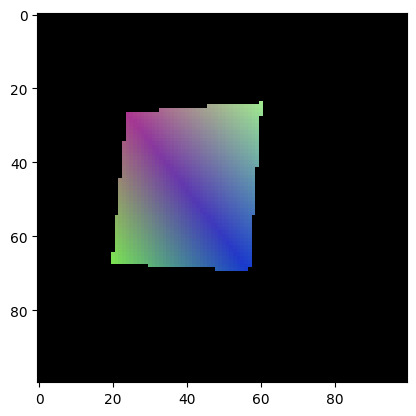

In [98]:
camera_pose = Pose.from_position_and_target(
    jnp.array([0.0, 5.0, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    up=jnp.array([0,0,1])
)
rotation_y = b3d.Rot.from_euler('y', jnp.pi/3, degrees=False).quat
pose_y = Pose(jnp.array([0,0,0]), rotation_y)
rotation_x = b3d.Rot.from_euler('x', jnp.pi/2, degrees=False).quat
pose_x = Pose(jnp.array([0,0,0]), rotation_x)
rotation_z = b3d.Rot.from_euler('z', jnp.pi/20, degrees=False).quat
pose_z = Pose(jnp.array([0,0,0]), rotation_z)
pose = pose_x @ pose_y @ pose_z
# pose = Pose.identity()
obj_id = 0

rgb_img, depth = renderer.render_attribute((camera_pose.inv() @ pose)[None,...], 
                                            vertices, 
                                            faces.astype(int), 
                                            object_library.ranges[jnp.array([obj_id])], 
                                            vertex_colors)
print(object_library.vertices.shape, object_library.faces.shape, object_library.attributes.shape)
plt.imshow(rgb_img)


In [99]:
def subdivide(
    vertices, faces, face_index=None, vertex_attributes=None, return_index=False
):
    if face_index is None:
        face_mask = np.ones(len(faces), dtype=bool)
    else:
        face_mask = np.zeros(len(faces), dtype=bool)
        face_mask[face_index] = True

    # the (c, 3) int array of vertex indices
    faces_subset = faces
    print(f"faces={faces.shape}, faces_subset={faces_subset.shape}")

    # find the unique edges of our faces subset
    edges = np.sort(trimesh.remesh.faces_to_edges(faces_subset), axis=1)
    unique, inverse = trimesh.grouping.unique_rows(edges)
    # then only produce one midpoint per unique edge
    mid = vertices[edges[unique]].mean(axis=1)
    mid_idx = inverse.reshape((-1, 3)) + len(vertices)

    # the new faces_subset with correct winding
    f = np.column_stack(
        [
            faces_subset[:, 0],
            mid_idx[:, 0],
            mid_idx[:, 2],
            
            mid_idx[:, 0],
            faces_subset[:, 1],
            mid_idx[:, 1],
            
            mid_idx[:, 2],
            mid_idx[:, 1],
            faces_subset[:, 2],
            
            mid_idx[:, 0],
            mid_idx[:, 1],
            mid_idx[:, 2],
        ]
    ).reshape((-1, 3))

    # add the 3 new faces_subset per old face all on the end
    # by putting all the new faces after all the old faces
    # it makes it easier to understand the indexes
    new_faces = np.vstack((faces[~face_mask], f))
    # stack the new midpoint vertices on the end
    new_vertices = np.vstack((vertices, mid))

    if vertex_attributes is not None:
        attr_tris = vertex_attributes[faces_subset]
        attr_mid = np.vstack(
            [attr_tris[:, g, :].mean(axis=1) for g in [[0,1],[1,2],[2,0]]]
        )
        attr_mid = attr_mid[unique]
        new_attributes = np.vstack((vertex_attributes, attr_mid))
        return new_vertices, new_faces, new_attributes

    return new_vertices, new_faces

In [100]:
new_v, new_f, new_c = subdivide(vertices, 
                                faces,
                                vertex_attributes=vertex_colors 
                                        )
new_v.shape, new_f.shape, new_c.shape

faces=(2, 3), faces_subset=(2, 3)


((29, 3), (8, 3), (29, 3))

(29, 3) (8, 3) (29, 3)


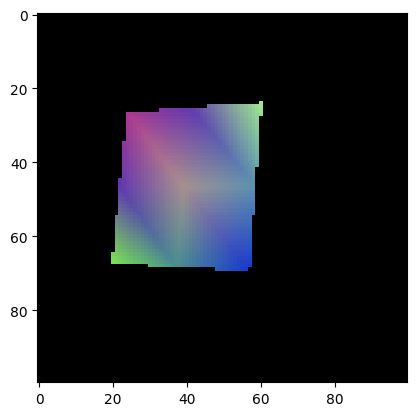

In [101]:
rgb_img_subdivided, depth = renderer.render_attribute((camera_pose.inv() @ pose)[None,...],
                                            new_v, 
                                            new_f, 
                                            jnp.array([[0, new_f.shape[0]]]), 
                                            new_c)
print(new_v.shape, new_f.shape, new_c.shape)
plt.imshow(rgb_img_subdivided)

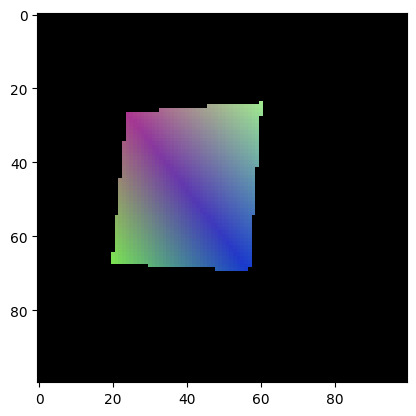

In [102]:
plt.imshow(rgb_img)